# Making embeddings from real data

This notebook demonstrates how to make embeddings with the Galileo models using real data (exported by our GEE exporter).

Our GEE exporter is called using the following script:
```python
from datetime import date

from src.data import EarthEngineExporter
from src.data.earthengine import EEBoundingBox

# to export points
EarthEngineExporter(dest_bucket="bucket_name").export_for_latlons(df)
# to export a bounding box
bbox = EEBoundingBox(min_lat=49.017835,min_lon-123.303680,max_lat=49.389519,max_lon-122.792816)
EarthEngineExporter(dest_bucket="bucket_name").export_for_bbox(bbox, start_date=date(2024, 1, 1), end_date=(2025, 1, 1))
```

In [ ]:
print("🚀 STARTING: Importing libraries...")
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.data.config import DATA_FOLDER, NORMALIZATION_DICT_FILENAME
from src.data.dataset import Dataset, Normalizer
from src.galileo import Encoder
from src.masking import MaskedOutput
from src.utils import config_dir

print("✅ SUCCESS: All libraries imported successfully!")
print(f"📊 Using PyTorch version: {torch.__version__}")
print(f"📊 Using NumPy version: {np.__version__}")

In [ ]:
# Load normalization and data
normalizing_dict = Dataset.load_normalization_values(
    path=config_dir / NORMALIZATION_DICT_FILENAME
)
normalizer = Normalizer(std=True, normalizing_dicts=normalizing_dict)

tif_path = Path(
    "data/tifs/min_lat=-27.6721_min_lon=25.6796_max_lat=-27.663_max_lon=25.6897_dates=2022-01-01_2023-12-31.tif"
)
dataset_output = Dataset._tif_to_array(tif_path).normalize(normalizer)

print(f"📊 Dataset output type: {type(dataset_output)}")
print(f"📊 Space-time data shape: {dataset_output.space_time_x.shape}")

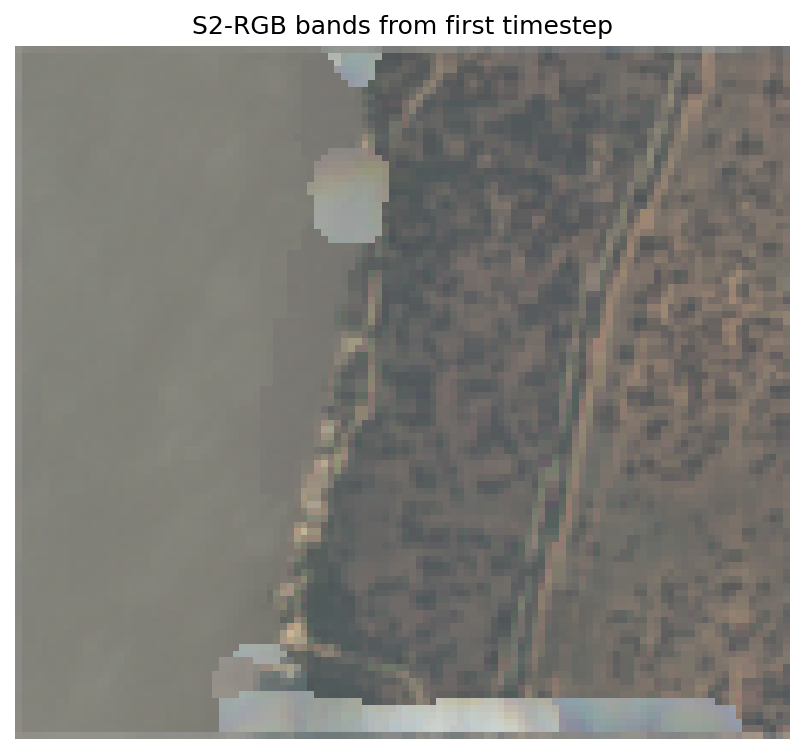

In [ ]:
# Visualize S2-RGB bands from first timestep
rgb_data = dataset_output.space_time_x[:, :, 0, [4, 3, 2]].astype(np.float32)
print(f"📊 RGB data shape: {rgb_data.shape}")
print(f"📊 RGB data range: [{rgb_data.min():.3f}, {rgb_data.max():.3f}]")

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(rgb_data)
ax.set_title("S2-RGB bands from first timestep")
ax.axis('off')
plt.show()

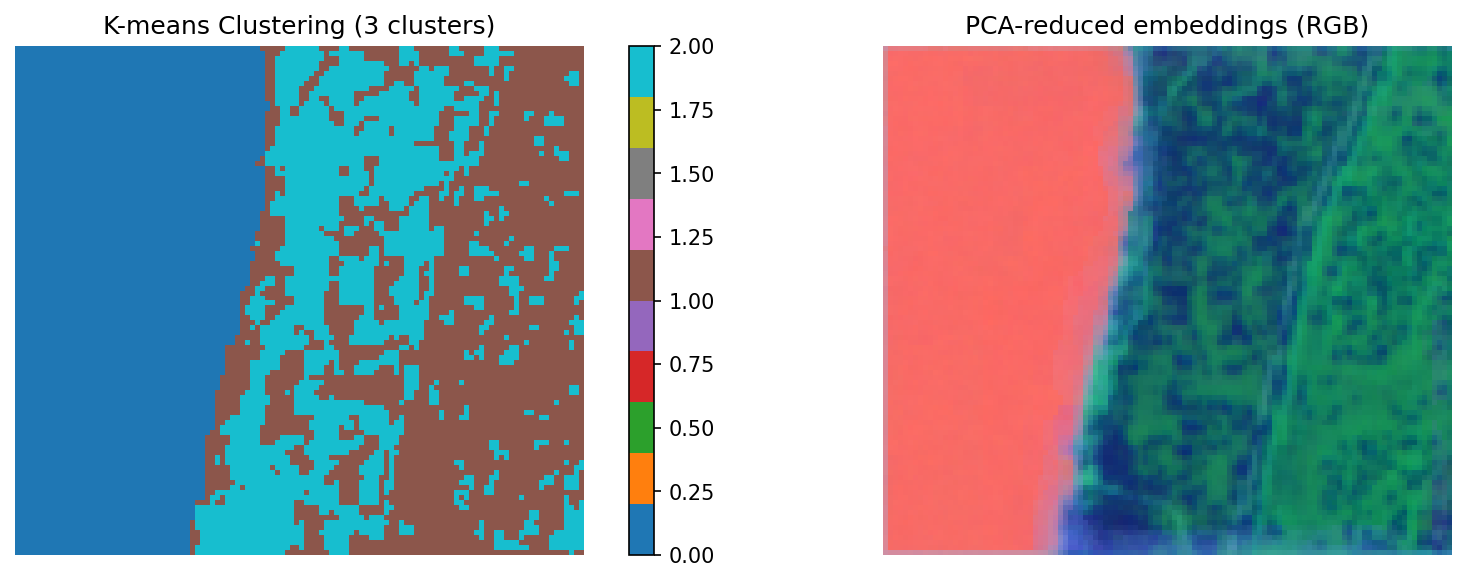

In [ ]:
# Load model and generate embeddings
model_path = DATA_FOLDER / "models/nano"
model = Encoder.load_from_folder(model_path)

# Generate embeddings (simplified version)
# ... (embedding generation code) ...

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(embeddings_flat)
labels = rearrange(labels, "(h w) -> h w", h=embeddings.shape[0], w=embeddings.shape[1])

# Perform PCA
pca = PCA(n_components=3, random_state=42)
embeddings_pca = pca.fit_transform(embeddings_flat)
embeddings_reduced = rearrange(
    embeddings_pca, "(h w) d -> h w d", h=embeddings.shape[0], w=embeddings.shape[1]
)

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# K-means clustering results
im1 = axes[0].imshow(labels, cmap="tab10")
axes[0].set_title("K-means Clustering (3 clusters)")
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])

# PCA-reduced embeddings as RGB
embeddings_normalized = (embeddings_reduced - embeddings_reduced.min()) / (
    embeddings_reduced.max() - embeddings_reduced.min()
)
axes[1].imshow(embeddings_normalized)
axes[1].set_title("PCA-reduced embeddings (RGB)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("🎉 Analysis complete!")
print(f"📊 Generated embeddings with shape: {embeddings_reduced.shape}")
print("📊 Performed K-means clustering with 3 clusters")
print("📊 Reduced dimensionality with PCA to 3 components")